In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(1234567)

In [24]:
# Read the data into a pandas dataframe
wine_data = pd.read_csv('./wine-classification-missing.csv', sep=';', index_col=0)

# View 10 random rows of the data
train = wine_data.sample(10)

# Convert the DataFrame to a NumPy array for shuffling
wine_data_array = wine_data.to_numpy()

# Shuffle the rows using rng.shuffle
rng.shuffle(wine_data_array)

# Convert the shuffled array back to a DataFrame
wine_data_rng = pd.DataFrame(wine_data_array, columns=wine_data.columns)

#Split data set
train_set_value = round(0.7 * len(wine_data_rng))
val_set_value = round(0.15 * len(wine_data_rng))
test_set_value = round(0.15 * len(wine_data_rng))


#Take the first 70% of data from dataset
wine_data_train_set = wine_data_rng.iloc[:train_set_value]
#Take 15%
wine_data_val_set = wine_data_rng.iloc[train_set_value: train_set_value + val_set_value]
#Store the rest
wine_data_test_set = wine_data_rng.iloc[(train_set_value)+ val_set_value:]

#Set training sample
train_set_sample = wine_data_train_set

In [25]:
# Fill NaN values with means and standardize the data
def filter_data(data):
    #Stores all collumns with Nan values
    features_with_nan = data.columns[data.isna().any()]
    
    #Finds mean of each column that has NaN values
    features_means = data[features_with_nan].mean()
    
    #Fill the NaN values with the means for each specific column
    data_cleaned = data.fillna(features_means)
    
    #Store the data class for later use
    data_label = data_cleaned['class']
    
    #Drop class for calculations
    data_without_class = data_cleaned.drop('class', axis=1)
    
    #Find the mean and standard deviation and store it
    mean_values = data_without_class.mean()
    std_values = data_without_class.std()
    
    #Standardization for each feature
    standardized_data = (data_without_class - mean_values) / std_values
    
    return standardized_data, data_label, mean_values, std_values

train_set_standardized, train_set_label, mean_train_set, std_train_set = filter_data(wine_data_train_set)
print(mean_train_set)

alcohol                  13.005920
malic_acid                2.350660
ash                       2.388960
alcalinity_ash           19.742400
magnesium               100.144000
total_phenols             2.264400
flavanoids                1.998320
nonflavanoid_phenols      0.363040
proanthocyanins           1.573200
color_intensity           4.991920
hue                       0.950519
OD280_OD315               2.602547
proline                 749.408000
dtype: float64


Accuracy: 0.992


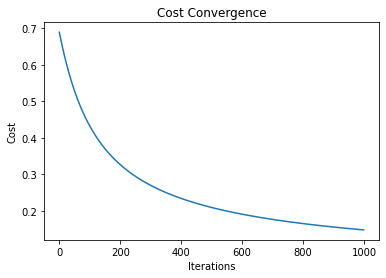

In [26]:
#Set ytrain to the class feature
yTrain = train_set_label
#set xtrain to all features beside class
XTrain = train_set_standardized
# Add a column of ones called bias to the DataFrame, making it now a design matrix
XTrain['bias'] = 1

# Get the number of training examples
samples_len = len(yTrain)


#Compute the cost function for logistic regression with L2 regularization.
def compute_cost(targets, design_matrix, lambda_val, params):
    
    # Calculate the predicted probabilities using the logistic function
    predicted_prob = logistic(np.dot(design_matrix, params))
    
    # Calculate the L2 regularization to penalize the large parameter values
    l2_regression = (lambda_val / (2*samples_len)) * np.sum(params[1:]**2)
    
    # Calculate the logistic regression cost function with L2 regularization
    cost = (-1 / samples_len) * (np.dot(targets.T, np.log(predicted_prob)) + 
                       np.dot((1 - targets).T, np.log(1 - predicted_prob))) + l2_regression
    return cost

def gradient_descent(targets, design_matrix, alpha, lambda_val, params, iterations):
    
    #create empty array to use later
    costs = []
    
    for iteration in range(iterations):
        
        # calculate the predicted probabilities
        predicted_prob = logistic(np.dot(design_matrix, params))
        
        #calculate the gradient
        gradient = (1 / samples_len) * np.dot(design_matrix.T, (predicted_prob - targets))
        
        #Apply the L2 regularization to the gradient (not including the bias)
        gradient[1:] += (lambda_val / samples_len) * params[1:]
        
        #Update the parameters
        params -= alpha * gradient
        
        #calculate and store the costs for monitoring the convergence
        cost = compute_cost(targets, design_matrix, lambda_val, params)
        
        #Add to list
        costs.append(cost)
        
    return params, costs


#Set Variables
# Initialize parameters to zeros
initial_params = np.zeros(XTrain.shape[1])

# Set the learning rate
alpha = 0.01

# Set the regularization parameter
lambda_val = 0.1

params, costs = gradient_descent(yTrain, XTrain, alpha, lambda_val, initial_params, iterations=1000)

# Use the final parameters to make predictions
predicted_classes = (logistic(np.dot(XTrain, params)) >= 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(predicted_classes == yTrain)
print(f"Accuracy: {accuracy}")

# Plot the cost over iterations
plt.plot(costs)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Convergence')
plt.show()

In [27]:
#Filter the val set
val_set_standardized, val_set_label, mean_val_set, std_val_set = filter_data(wine_data_val_set)

#Set ytrain to the class feature
yVal = val_set_label

#set xtrain to all features beside class
XVal = val_set_standardized

# Add a column of ones called bias to the DataFrame, making it now a design matrix
XVal['bias'] = 1

# Get the number of training examples
samples_val_len = len(yVal)

In [28]:
#Sigmoid function
def logistic(z):
    return 1 / (1 + np.exp(-z)) #1/1+e-z


# measures the difference between the predicted probabilities and the true labels
def bce_loss(X, y, w, gamma):
    
    # Calculate the predicted probabilities using the logistic function
    predicted_prob = logistic(np.dot(X, w))
    
    # Calculate the L2 regularization to penalize the large parameter values for bce
    l2_regression = (gamma / (2*len(y))) * np.sum(w[1:]**2)
    
    # Calculate the binary cross-entropy loss with L2 regularization
    loss = (1 / len(y)) * (np.dot(y.T, np.log(predicted_prob)) + 
                       np.dot((1 - y).T, np.log(1 - predicted_prob))) + l2_regression
    
    return loss

def mgd_optimizer(X, y, gamma, eta, S, max_iters):

    weights = np.zeros(X.shape[1])
    
    for iteration in range(max_iters):
        # Select random minibatch of size S
        rand_batch = np.random.choice(len(y), S, replace=False)
        X_batch = X.iloc[rand_batch]
        y_batch = y.iloc[rand_batch]
        
        #Calculate the preicted probabilities
        predicted_prob = logistic(np.dot(X_batch, weights))
        
        #calculate gradient
        gradient = (1 / S) * np.dot(X_batch.T, (predicted_prob - y_batch))
        
        #Applt the l2 reg to the gradient, not including bias
        gradient[1:] += (gamma / len(y)) * weights[1:]
        
        #Update weights
        weights -= eta * gradient
        
    return weights


In [29]:
# Grid of values for gamma, eta, and S
num = 10
gamma_vector = np.logspace(-4, -1, num)
eta_vector = np.logspace(-5, -1, num)
S_vector = np.linspace(1, 15, num)
best_loss = float('inf')

for gamma in gamma_vector:
    for eta in eta_vector:
        for S in S_vector:
            # Use mgd_optimizer to compute weights with given gamma, eta, and S
            weights = mgd_optimizer(XTrain, yTrain, gamma, eta, int(S), max_iters=150)

            # Use the computed weights to calculate the loss on the validation set
            validation_loss = bce_loss(XVal, yVal, weights, gamma)

            # Check if the current validation loss is the smallest so far
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_weights = weights
                best_gamma = gamma
                best_eta = eta
                best_S = int(S)


# Print and save the best values
print("Best gamma:", best_gamma)
print("Best eta:", best_eta)
print("Best loss:", best_loss)
print("Best S:", best_S)

Best gamma: 0.004641588833612777
Best eta: 1e-05
Best loss: -0.6924884329185288
Best S: 1


In [30]:
#Combine the validation and test set and then filter it
combined_wine_data = pd.concat([wine_data_val_set, wine_data_test_set], axis=0, ignore_index=True)
combined_set_standardized, combined_set_label, mean_combined_set, std_combined_set = filter_data(combined_wine_data)

#Set ytrain to the class feature
y_combined = combined_set_label

#set xtrain to all features beside class
X_combined = combined_set_standardized

# Add a column of ones called bias to the DataFrame, making it now a design matrix
X_combined['bias'] = 1

# Use mgd_optimizer to compute weights with given gamma, eta, and S
weights = mgd_optimizer(X_combined, y_combined, best_gamma, best_eta, best_S, max_iters=150)

# Use the computed weights to calculate the loss
combined_loss = bce_loss(X_combined, y_combined, best_weights, best_gamma)


# Preprocess the test data using the saved mean and std values
test_set_cleaned = wine_data_test_set.fillna(mean_combined_set)
test_set_standardized = (test_set_cleaned - mean_combined_set) / std_combined_set

# Set y_test to the class feature
y_test = test_set_cleaned['class']

# Set x_test to all features beside class
X_test = test_set_standardized.drop('class', axis=1)

# Add a column of ones called bias to the DataFrame, making it a design matrix
X_test['bias'] = 1

In [31]:
# Reporting Test Metrics #

# Use mgd_optimizer to compute weights with the optimal gamma, eta, and S on the test set
weights_test = mgd_optimizer(X_test, y_test, best_gamma, best_eta, best_S, max_iters=150)

# Use the computed weights to calculate the binary cross-entropy loss on the test set
test_loss = bce_loss(X_test, y_test, weights_test, best_gamma)

# Use the final parameters to make predictions on the test set
predicted_classes_test = (logistic(np.dot(X_test, weights_test)) >= 0.5).astype(int)

# Calculate accuracy on the test set
accuracy_test = np.mean(predicted_classes_test == y_test)

# Calculate precision and recall on the test set
true_positives = np.sum((predicted_classes_test == 1) & (y_test == 1))
false_positives = np.sum((predicted_classes_test == 1) & (y_test == 0))
false_negatives = np.sum((predicted_classes_test == 0) & (y_test == 1))

precision_test = true_positives / (true_positives + false_positives)
recall_test = true_positives / (true_positives + false_negatives)

# Print the results
print("Test Binary Cross-Entropy Loss:", test_loss)
print("Test Accuracy:", accuracy_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)

Test Binary Cross-Entropy Loss: -0.6925113873609788
Test Accuracy: 0.8461538461538461
Test Precision: 0.7272727272727273
Test Recall: 0.8888888888888888
